In [1]:
import pandas as pd
import numpy as np
import scipy.io as sio
from scipy import stats
import os, time, h5py, sys, glob, pickle, random, configparser
from tqdm import tqdm
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
from PIL import Image
from sklearn.metrics.pairwise import euclidean_distances

import matplotlib.pyplot as plt
plt.ioff() # Turn off interactive mode
import nibabel as nib
from nilearn import plotting, surface
import seaborn as sns
from itertools import combinations, product

In [2]:
sub_list = range(1,9)
exp_config = configparser.ConfigParser()
exp_config.read('../config')
# Set the directories
NSD_top_dir = exp_config['DIR']['NSD_top_dir']
output_fig_dir = os.path.join(NSD_top_dir, 'figures', 'Manuscript')

In [3]:
roi_list = ['lPFC', 'Visual']

In [4]:
stimuli_dir = os.path.join(NSD_top_dir,
                           'data',
                          'nsddata_stimuli',
                          'stimuli',
                          'nsd',
                          'nsd_stimuli.hdf5')
f1 = h5py.File(stimuli_dir,'r')

In [5]:
pred_results_dir = os.path.join(NSD_top_dir,
                               'results',
                               'Pred_activation')
count = 0
for curr_sub in sub_list:
    for curr_roi in roi_list:
        _df = pd.read_csv(os.path.join(pred_results_dir,
                                      'sub0{}_{}.csv'.format(curr_sub, curr_roi)))
        _df['SUB'] = curr_sub
        _df['ROI'] = curr_roi
        if count == 0:
            count += 1
            all_summary_df = _df
        else:
            all_summary_df = pd.concat([all_summary_df, _df]).reset_index(drop=True)

In [6]:
# Visualize the top vs. bottom
for curr_sub in sub_list:
    for curr_roi in roi_list:
        curr_df = all_summary_df[(all_summary_df['SUB']==curr_sub)&
                                (all_summary_df['ROI'] == curr_roi)].sort_values(by='activation').reset_index(drop=True)
        fig = plt.figure(figsize=(40, 40))
        sns.set(font_scale=2)
        sns.set_style('white')
        for i in range(36):
            a = fig.add_subplot(6, 6, i+1)
            img_ind = int(curr_df.iloc[-i-1]['img'])
            img_array = f1['imgBrick'][img_ind - 1, :, :, :]  # the 73k ID is 1-based, but python is 0-based
            img_obj = Image.fromarray(np.uint8(img_array)).convert('RGB')
            imgplot = plt.imshow(img_obj)
            a.axis("off")
            if i == 0:
                plt.title('sub0{}, {}+'.format(curr_sub,  curr_roi))
        plt.savefig(os.path.join(output_fig_dir, 'sub0{}_{}_top.pdf'.format(curr_sub, curr_roi)))
        plt.close(fig)

In [7]:
corr_sum_df = pd.DataFrame(columns=['ROI', 'SUB_1', 'SUB_2', 'Corr'])
for curr_roi in roi_list:
    for sub_pair in combinations(sub_list,2):
        df_1 = all_summary_df[(all_summary_df['SUB']==sub_pair[0])&
                             (all_summary_df['ROI']==curr_roi)]
        df_2 = all_summary_df[(all_summary_df['SUB']==sub_pair[1])&
                             (all_summary_df['ROI']==curr_roi)]
        merged_df = df_1.merge(df_2, on='img')
        curr_r, _ = stats.spearmanr(merged_df['activation_x'],
                      merged_df['activation_y'])
        corr_sum_df.loc[len(corr_sum_df)] = {'ROI':curr_roi,
                                             'SUB_1':sub_pair[0], 
                                             'SUB_2':sub_pair[1], 
                                             'Corr':curr_r}

In [8]:
corr_sum_df['Combination'] = [str(corr_sum_df['SUB_1'][k]) + '-' + str(corr_sum_df['SUB_2'][k]) for k in range(len(corr_sum_df))]

In [14]:
corr_sum_df.groupby(['ROI'])['Corr'].mean().round(2)

ROI
Visual    0.69
lPFC      0.52
Name: Corr, dtype: float64

In [15]:
corr_sum_df.groupby(['ROI'])['Corr'].std().round(2)

ROI
Visual    0.11
lPFC      0.19
Name: Corr, dtype: float64

In [10]:
corr_sum_df_lPFC = corr_sum_df[corr_sum_df['ROI']=='lPFC']
corr_sum_df_visual = corr_sum_df[corr_sum_df['ROI']=='Visual']
merged_df = corr_sum_df_lPFC.merge(corr_sum_df_visual, on='Combination')

In [16]:
stats.wilcoxon(merged_df['Corr_x'], merged_df['Corr_y'], mode='approx')

WilcoxonResult(statistic=47.0, pvalue=0.0003818181724051406)

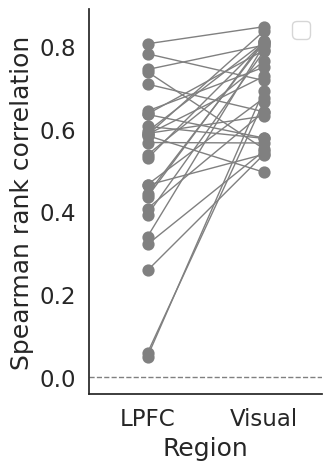

In [13]:
fig = plt.figure(figsize=(3,5))
sns.set(font_scale=1.5)
sns.set_style('white')
ax = sns.pointplot(x='ROI', y='Corr', hue='Combination', palette=['grey']*56, data=corr_sum_df)
plt.legend([])
ax.axhline(y=0, ls='--')
ax.set_ylabel("Spearman rank correlation")
ax.set_xticklabels(['LPFC', 'Visual'])
ax.set_xlabel('Region')
sns.despine(top=True, right=True)
lw = ax.lines[0].get_linewidth() # lw of first line
plt.setp(ax.lines,linewidth=1, color='gray')
plt.savefig(os.path.join(output_fig_dir, 'LPFC_VVS_corr.pdf'))
plt.show()